# 드라이브 연동

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 20 10:44:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
%cd /content/gdrive/My\ Drive/tobigs/snorrr

/content/gdrive/My Drive/tobigs/snorrr


In [0]:
#zip file을 내 드라이브에 다운받아야함
# !mkdir ./beep_data
# 가끔 압축이 안풀어져서 한번 더 해야하는 경우도 있음(A눌러서)
# !unzip XY_train.zip -d ./beep_data
# !unzip XY_test.zip -d ./beep_data

## melspectrogram과 melspectrogram의 n_freq 값은 다르다

In [0]:
n_freq = 1025
# n_freq = 128  # 스펙트로그램 높이 mel일떄  128

# Data Loader
- with Keras

In [6]:
%cd /content/gdrive/My\ Drive/tobigs/snorrr

/content/gdrive/My Drive/tobigs/snorrr


In [7]:
import os 
import pandas as pd
import numpy as np
from keras.utils import Sequence 

Using TensorFlow backend.


In [8]:
data_dir = os.path.join('.','beep_data', 'XY_train')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
df = pd.DataFrame({'x':x_s, 'y':y_s})
df.head()

,x,y
0,./beep_data/XY_train/x_0.npy,./beep_data/XY_train/y_0.npy
1,./beep_data/XY_train/x_1.npy,./beep_data/XY_train/y_1.npy
2,./beep_data/XY_train/x_10.npy,./beep_data/XY_train/y_10.npy
3,./beep_data/XY_train/x_100.npy,./beep_data/XY_train/y_100.npy
4,./beep_data/XY_train/x_1000.npy,./beep_data/XY_train/y_1000.npy


In [0]:
# # np.load(df.x[0]).shape, df.y
# for one_x, one_y in zip(df.x, df.y):
#     if np.load(one_x).shape!=(862, 128) or np.load(one_y).shape!=(212, 1):
#       print(one_x, one_y)
#       print(np.load(one_x).shape, np.load(one_y).shape)
    

In [9]:
# Train과 Valid로 나누기(Test말고)
train_ratio = 0.8
idxs = list(range(len(df)))
np.random.shuffle(idxs)
train_idx = idxs[:int(len(df)*train_ratio)]
valid_idx = idxs[int(len(df)*train_ratio):]

train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

print(train_df.shape, valid_df.shape)

(1600, 2) (400, 2)


In [10]:
data_dir = os.path.join('.','beep_data', 'XY_test')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
test_df = pd.DataFrame({'x':x_s, 'y':y_s})
test_df.head()

,x,y
0,./beep_data/XY_test/x_0.npy,./beep_data/XY_test/y_0.npy
1,./beep_data/XY_test/x_1.npy,./beep_data/XY_test/y_1.npy
2,./beep_data/XY_test/x_10.npy,./beep_data/XY_test/y_10.npy
3,./beep_data/XY_test/x_100.npy,./beep_data/XY_test/y_100.npy
4,./beep_data/XY_test/x_101.npy,./beep_data/XY_test/y_101.npy


In [0]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, shuffle = True, valid=False):
        self.X = list(df.x)
        self.y = list(df.y)
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.on_epoch_end()
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.floor(len(self.X) / self.batch_size))
    
    def __data_generation(self, X_list, y_list):
        X = []
        y = []
        
        for i, (img, label) in enumerate(zip(X_list, y_list)):
            np_img = np.load(img)
            np_label = np.load(label)
            if np_img.shape!=(862, 128):
              np_img = np.pad(np_img,((0,862-np_img.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            if np_label.shape!=(212, 1):
              np_label = np.pad(np_label,((0,212-np_label.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            X.append(np_img)
            y.append(np_label)
        
        # batch size 만큼 있던거 stack하기
        # for i in range(len(X)):
        #   print(X[i].shape,y[i].shape)
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)

        return X, y
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X_list = [self.X[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]
        # print(X_list, y_list)
        X, y = self.__data_generation(X_list, y_list)
        return X, y

In [0]:
train_generator = DataGenerator(train_df, 5)
valid_generator = DataGenerator(valid_df, 5, valid=True)
test_generator = DataGenerator(test_df, 3)

# 모두 공통적으로 돌려야 하는 부분

In [0]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
from keras.optimizers import Adam
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)

# Train

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, multiply
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [0]:
def make_model(input_shape):
    
    X_input = Input(shape = input_shape)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.4)(X)                                         # dropout (use 0.8)

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.4)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) # Batch normalization
    y = Activation("softmax")(X)
    X = multiply([y, X])
    

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.4)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) 
    y = Activation("softmax")(X)
    X = multiply([y, X])
    X = Dropout(0.4)(X)                                         # dropout (use 0.8)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    return model  

In [17]:
model = make_model(input_shape = (None, n_freq))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1025)   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 196)    3013696     input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 196)    784         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 196)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
# learing rate 100배 더 늘림
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.








In [0]:
# model 괜찮을때만 저장하기
from keras.callbacks import ModelCheckpoint
# keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# monitor = 어떤거 바탕으로 파악할거냐
# verbose 콘솔창에 어떻게 띄울지
# save_bast_only
# mode 최대값을 볼건지, 최소값을ㅇ 볼건지, monitor를 보고 알아서 파악할건지
MODEL_SAVE_PATH = './model/'
if not os.path.exists(MODEL_SAVE_PATH):
  os.mkdir(MODEL_SAVE_PATH)
# 저장할 파일 이름(저 괄호는 알아서 적어주는거겠지?)
model_path = MODEL_SAVE_PATH + '{epoch:02d}-{val_loss:.4f}_weight.hdf5'
cb_checkpoint = ModelCheckpoint(model_path,monitor='val_loss', verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto', period=1)

In [0]:
from keras.callbacks import EarlyStopping
# patience 해당 값이 안올라 가는 걸 몇번 허용하냐
# min_delta 어느정도 오차는 성능이 안나아졌다고 할거냐?

cb_earlystopping = EarlyStopping(monitor='val_loss', 
                            min_delta=0, patience=5, verbose=0, 
                            mode='auto', baseline=None, 
                            restore_best_weights=False)


## 모델 처음부터 돌리기

In [21]:
pwd

'/content/gdrive/My Drive/tobigs/snorrr'

In [22]:
model.load_weights("model/21-0.1867_weight.hdf5")
print("Loaded model from disk")

Loaded model from disk


In [27]:
model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs = 200,
                    callbacks = [cb_checkpoint, cb_earlystopping])     

Epoch 1/200
320/320 [==============================] - 144s 451ms/step - loss: 0.0430 - acc: 0.9842 - auc: 0.9938 - val_loss: 0.1223 - val_acc: 0.9646 - val_auc: 0.9938
Epoch 2/200
320/320 [==============================] - 142s 442ms/step - loss: 0.0461 - acc: 0.9832 - auc: 0.9938 - val_loss: 0.1320 - val_acc: 0.9625 - val_auc: 0.9938


In [25]:
 model.evaluate_generator(test_generator, steps=5)

[0.15857472717761995, 0.947169816493988, 0.9937658309936523]

In [0]:
# model save
# http://www.kwangsiklee.com/2019/03/keras에서-모델-saveload하기/
model_json = model.to_json()
with open("model4.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("model4_weight.h5")
print("Saved model to disk")

Saved model to disk


# 모델 또 불러와서 학습하기

In [0]:
pwd

'/content/gdrive/My Drive/tobigs/snorrr'

In [0]:
# model 구조랑 weight 얻어서 학습하기
from keras.models import model_from_json 
json_file = open("model_from_wow_wow.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("my_model_2_weights_2.h5")
print("Loaded model from disk")

In [0]:
# model 그대로 통째로 저장한 것 불러오기
# 이걸로는 왜 "학습"이 안되냐 ㅜㅜ freeze  된채로 쓸수는 있는데..
# # https://github.com/keras-team/keras/issues/10104
# # ('Could not interpret optimizer identifier:', <keras.optimizers.Adam object at 0x7f75a6b3d2b0>) optimizer를 새로 compile 해야하나?
# # 차원 안맞다는 오류 뜸
dependencies = {
     'auc': auc
}
loaded_model = tf.keras.models.load_model('my_model3.hdf5',  custom_objects=dependencies)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# # 만약에 모델 통쨰로 저장했을 때 weight만 저장!
model_json = loaded_model.to_json()
with open("my_model3_structure.json", "w") as json_file : 
    json_file.write(model_json)

loaded_model.save_weights("my_model3_weights.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [0]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])

In [0]:
loaded_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator, 
                    epochs = 3,
                    callbacks = [cb_checkpoint])     

In [0]:
# model save  
# http://www.kwangsiklee.com/2019/03/keras에서-모델-saveload하기/
model_json = loaded_model.to_json()
with open("model_from_test.json", "w") as json_file : 
    json_file.write(model_json)

loaded_model.save_weights("model_from_test.h5")
print("Saved model to disk")

Saved model to disk


# 모델 불러와서 바로 predict하기
dependencies = {
     'auc': auc
}<br/>
my_model = load_model('model/52-0.1981.hdf5', custom_objects=dependencies)<br/>
가장 최대 정확도를 가진게52-0.1881임 -> my_model로 저장

In [0]:
from keras.models import model_from_json 
# json_file = open("my_model3_structure.json", "r")
# loaded_model_json = json_file.read() 
# loaded_model = model_from_json(loaded_model_json)
# json_file.close()

# loaded_model.load_weights("my_model3_weights.h5")
# print("Loaded model from disk")
# loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])
# loaded_model.evaluate_generator(test_generator, steps=5)

model.load_weights("my_model3_weights.h5")
print("Loaded model from disk")
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])
model.evaluate_generator(test_generator, steps=5)

Loaded model from disk


[0.31545465290546415, 0.8710691928863525, 0.8481353282928467]

# Test

In [0]:
def postprocessing(outputs, th):
    for output in outputs:
        output[output<th] = 0
        output[output>=th] = 1
    return outputs

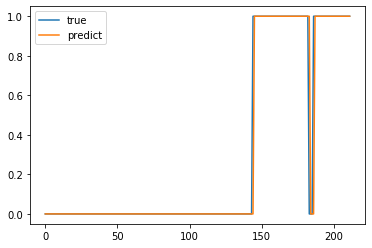

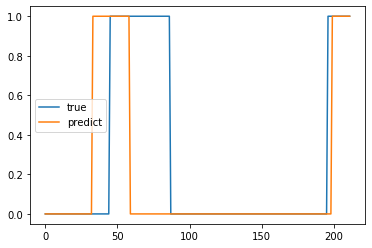

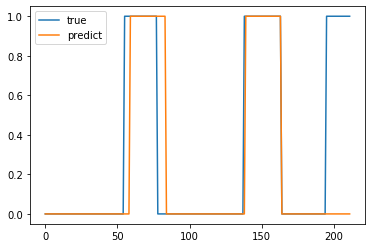

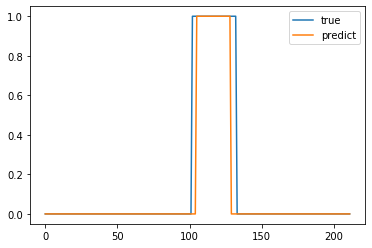

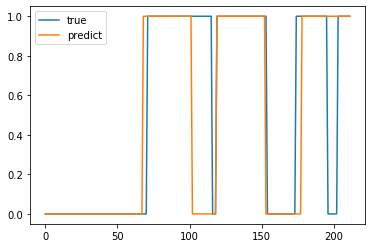

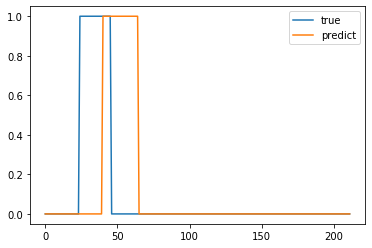

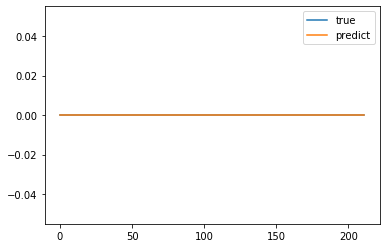

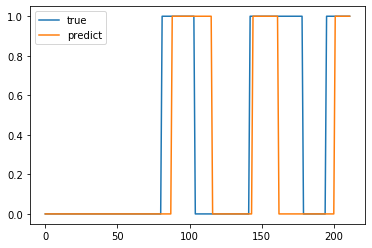

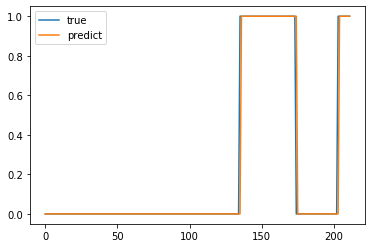

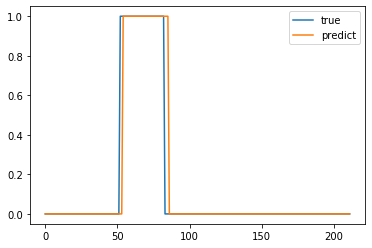

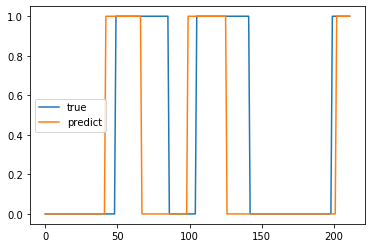

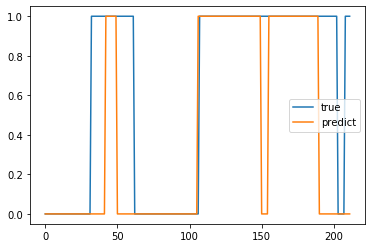

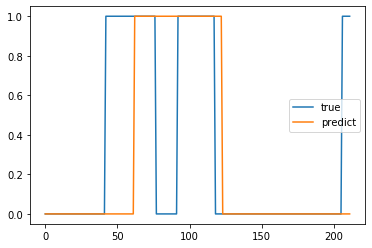

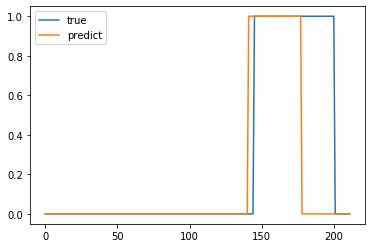

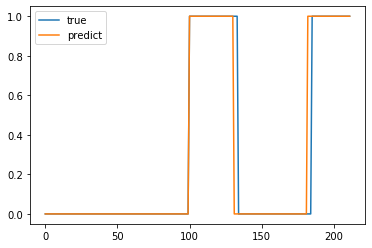

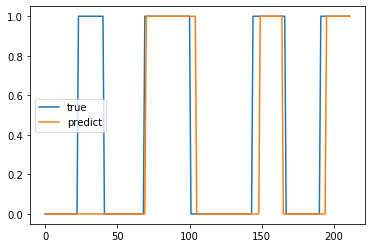

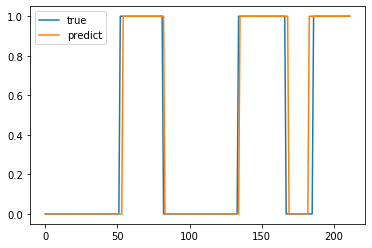

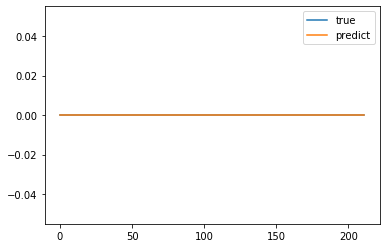

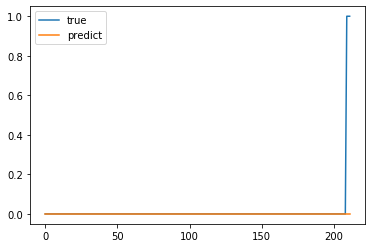

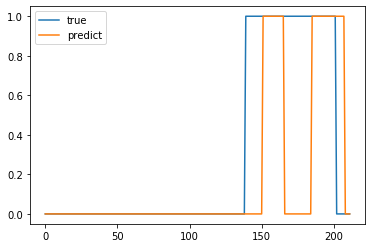

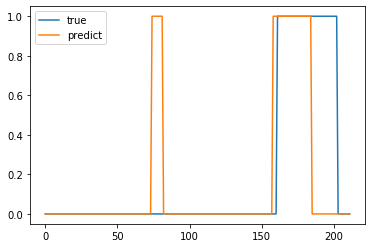

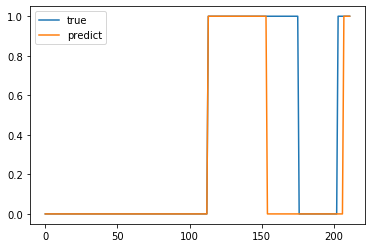

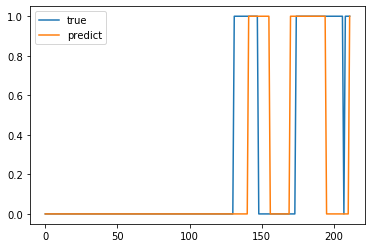

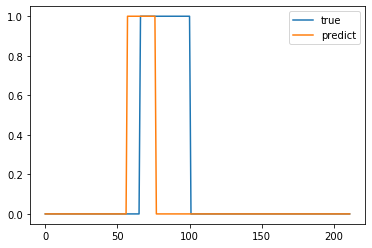

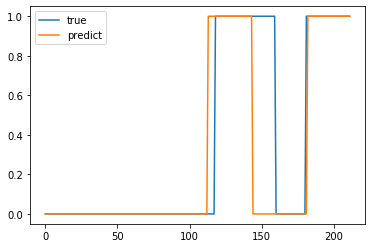

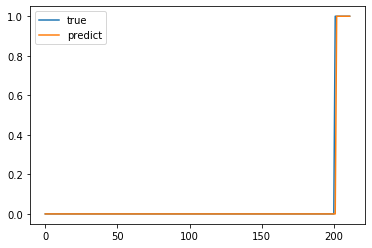

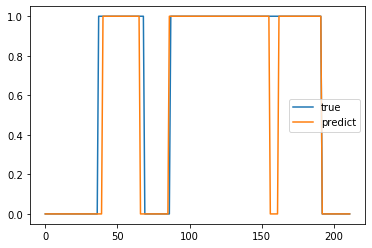

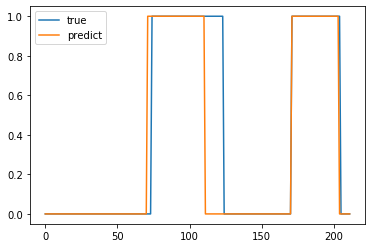

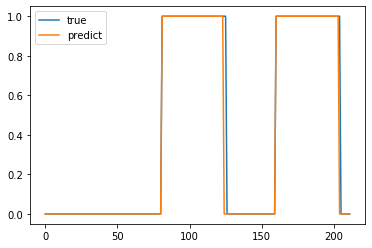

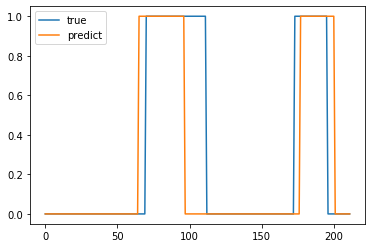

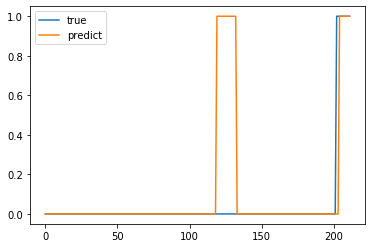

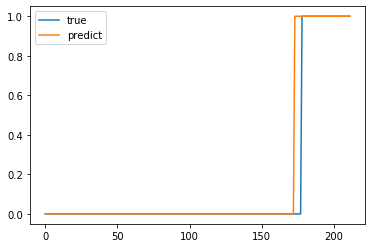

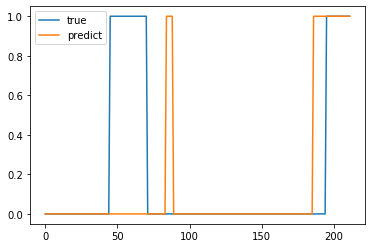

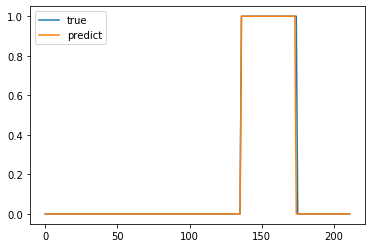

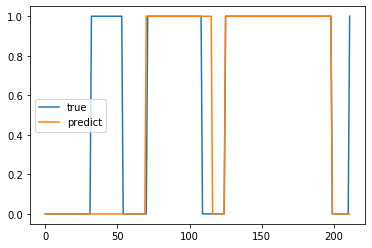

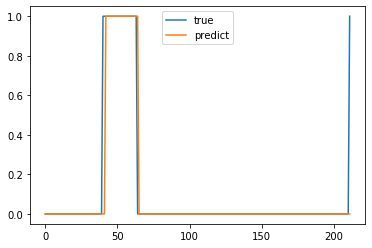

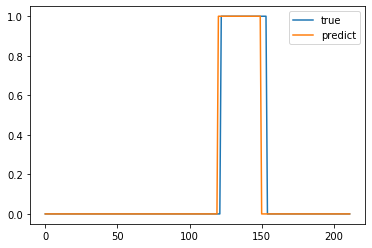

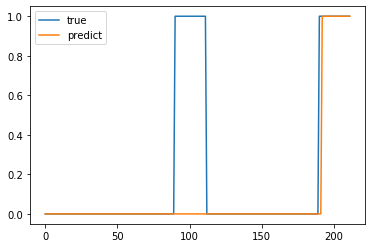

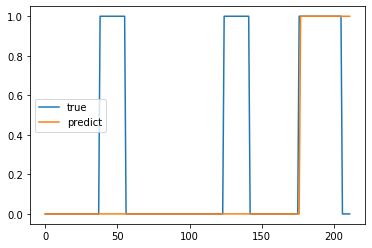

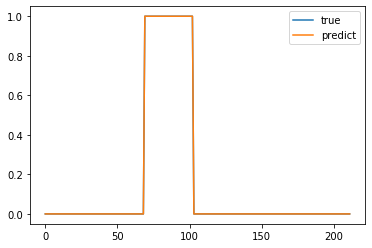

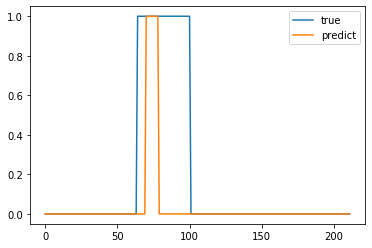

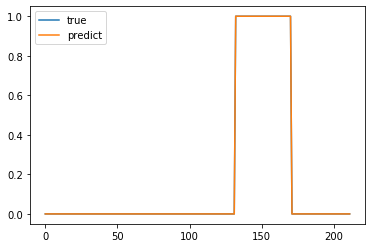

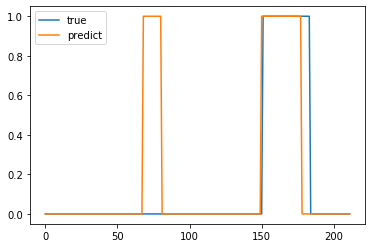

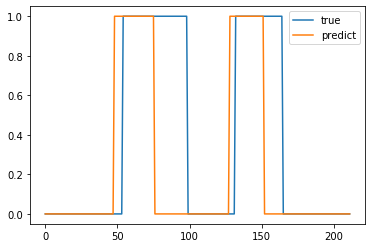

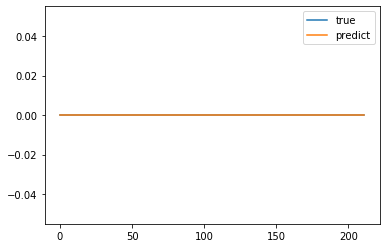

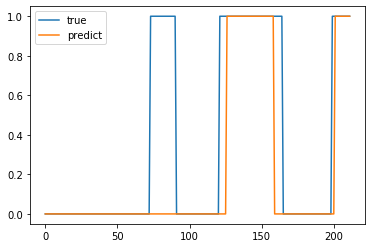

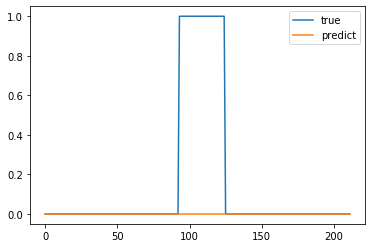

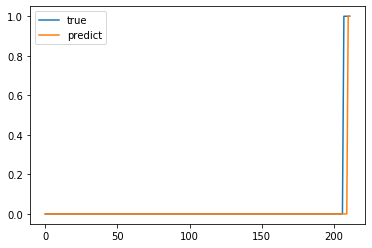

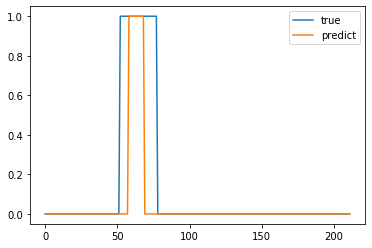

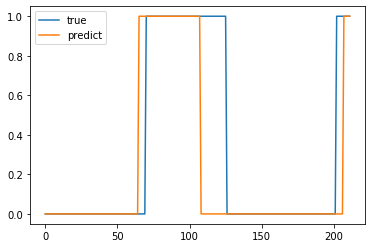

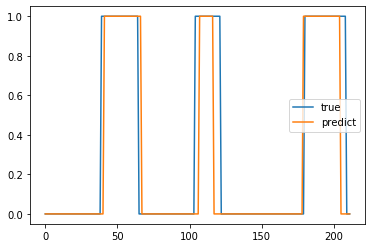

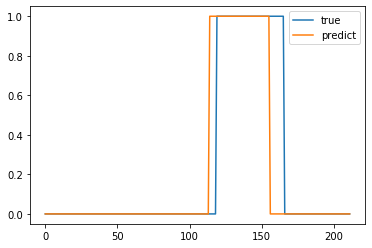

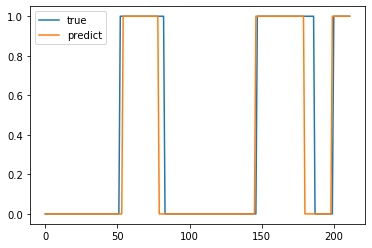

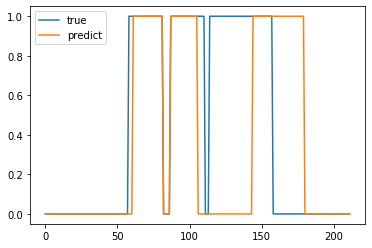

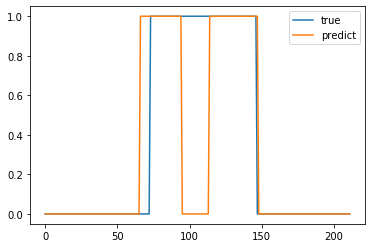

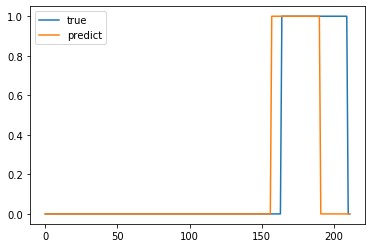

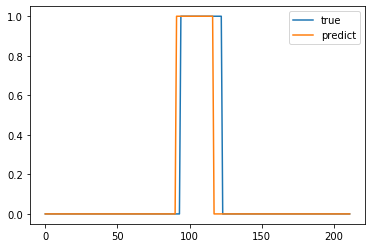

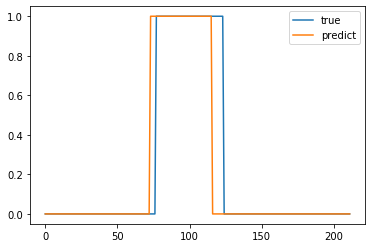

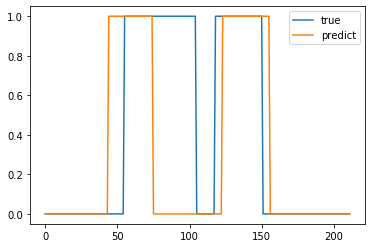

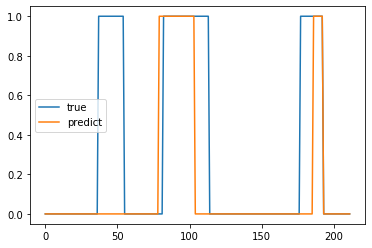

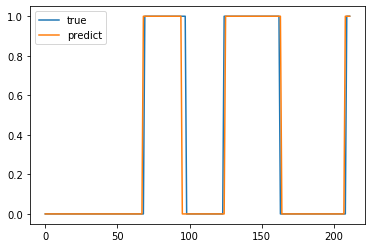

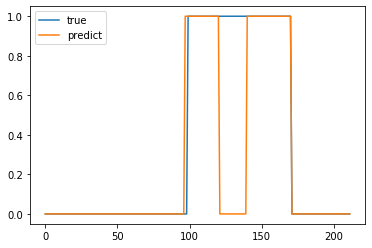

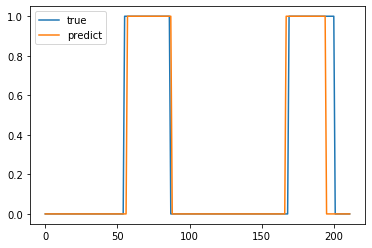

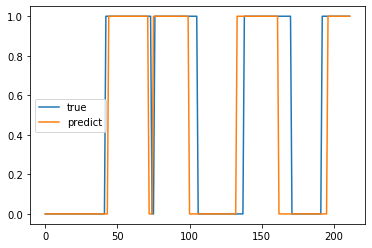

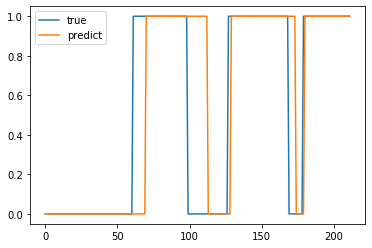

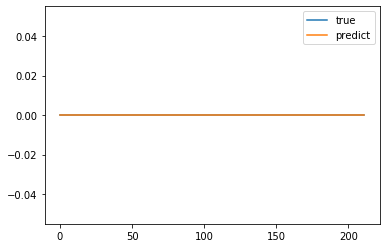

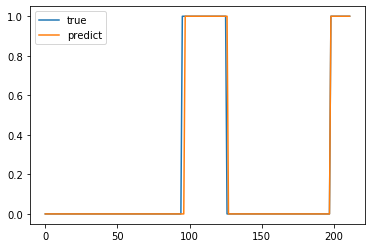

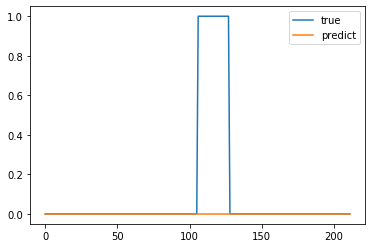

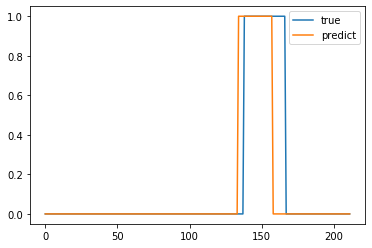

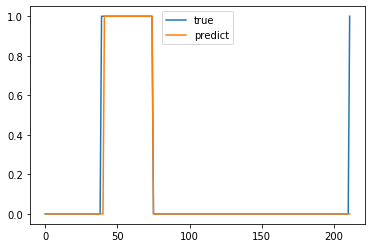

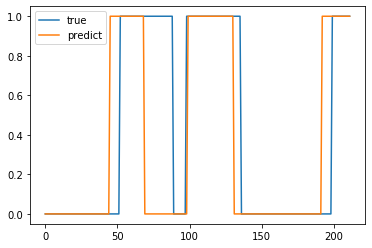

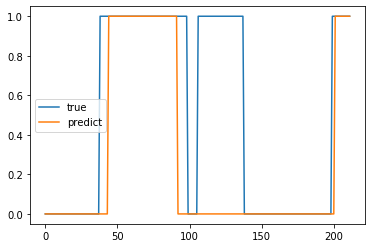

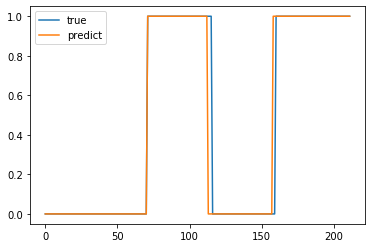

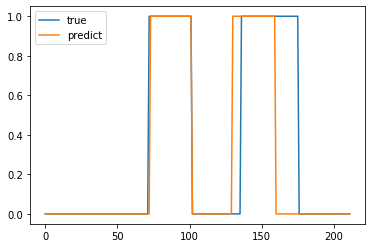

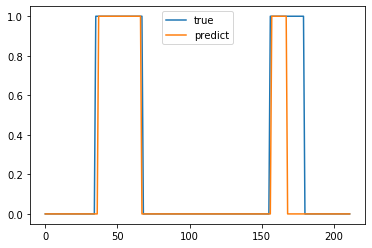

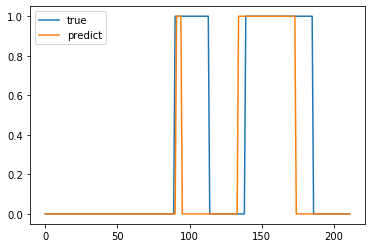

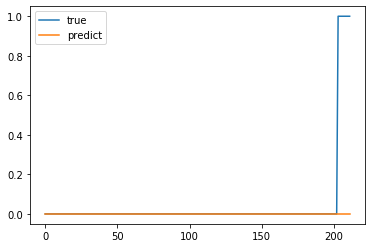

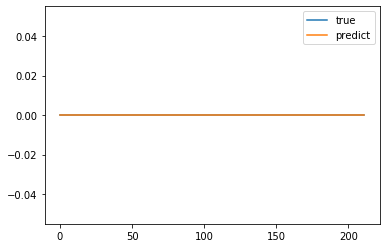

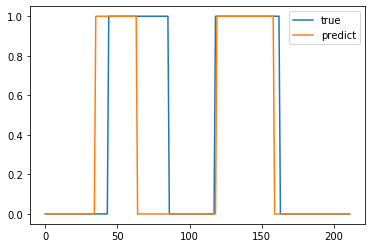

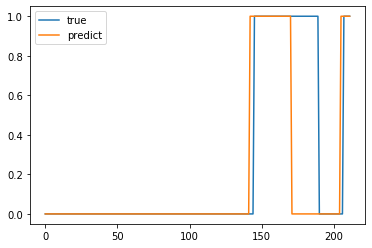

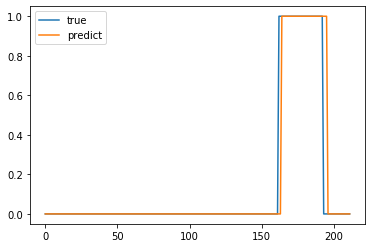

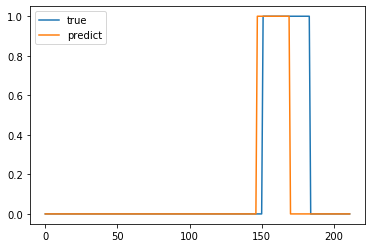

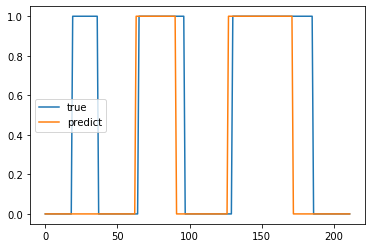

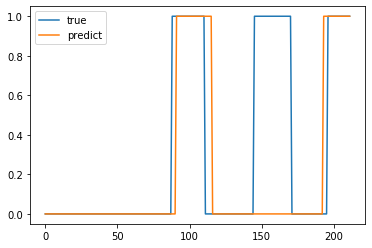

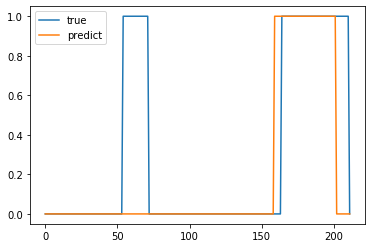

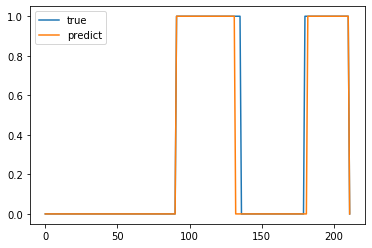

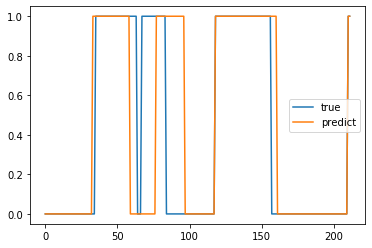

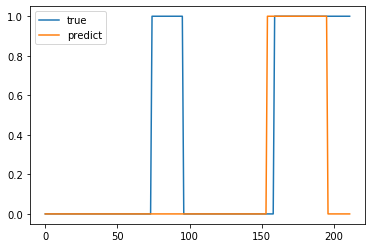

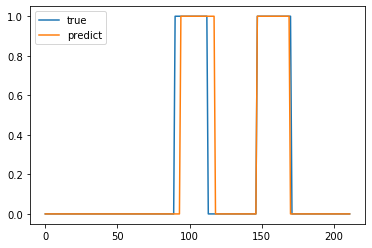

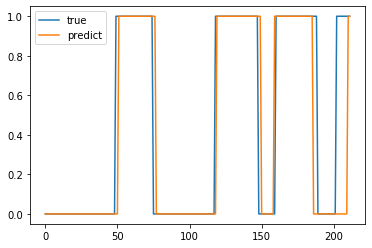

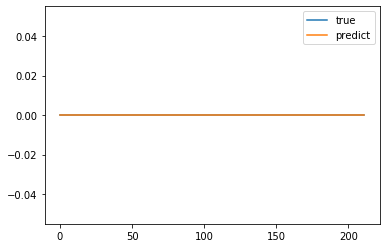

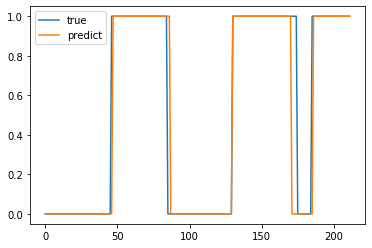

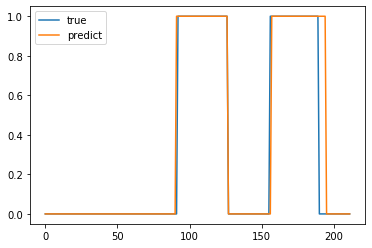

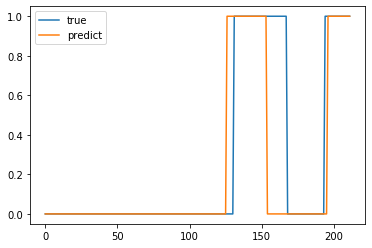

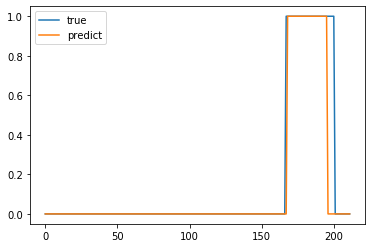

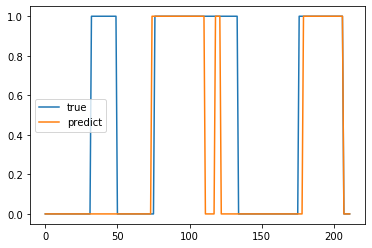

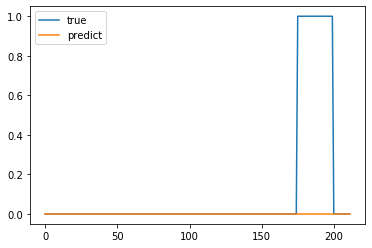

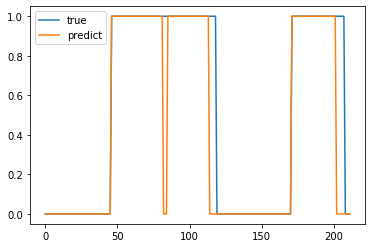

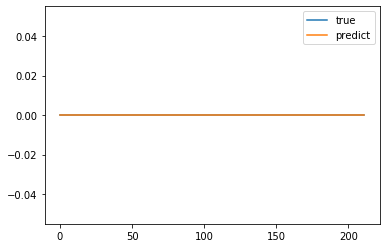

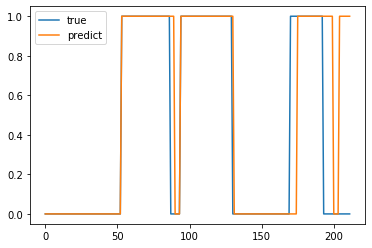

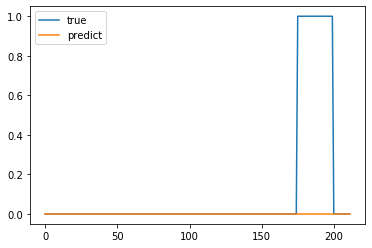

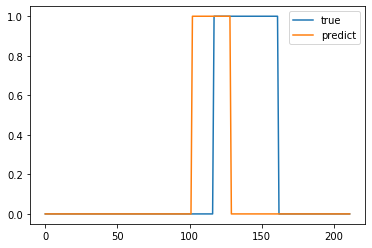

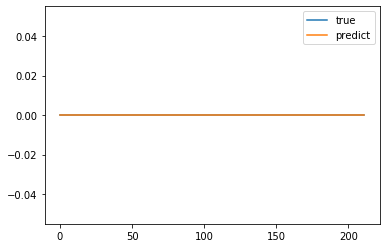

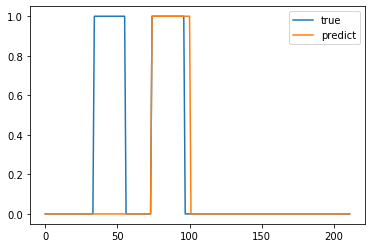

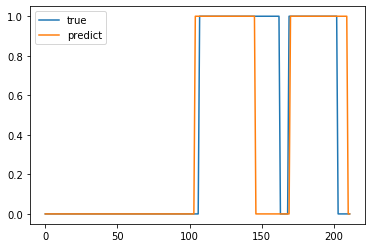

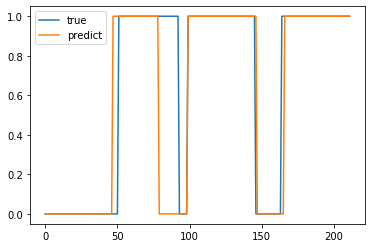

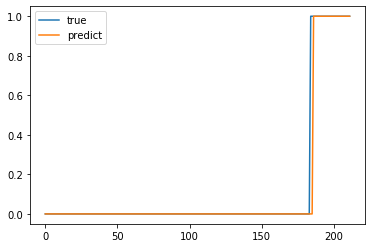

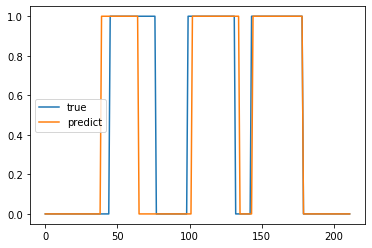

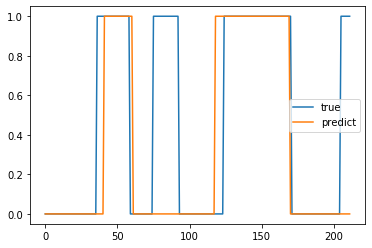

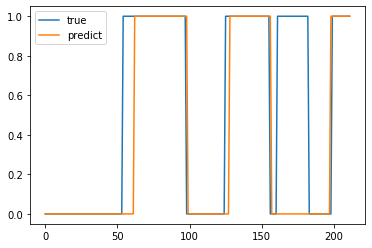

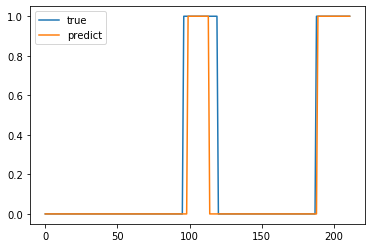

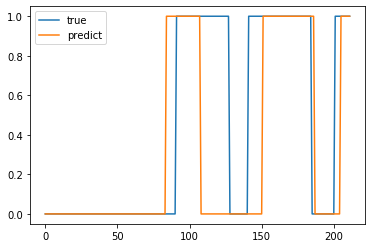

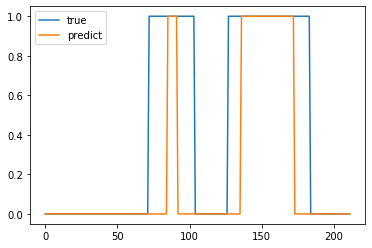

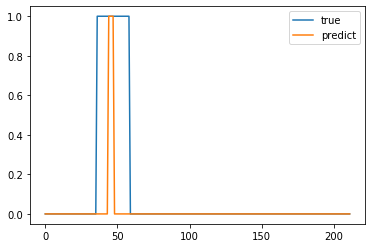

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
for batch in test_generator:
    x, y = batch
    output = my_model.predict(x)
    output = postprocessing(output,0.6) # threshold 0.6으로 지정
    for i in range(len(y)):
        plt.plot(y[i], label='true')
        plt.plot(output[i], label='predict')
        plt.legend()
        plt.show()